In [18]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

In [19]:
pizza_df = pd.read_csv('pizza_data.csv').drop('Unnamed: 0', axis = 1)
pizza_df.head()

,id,Neighb,Restaurant,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,0.0,0.0,0.0,0.0,0.0,0.0,37.0,62.0
1,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,1.0,0.0,0.0,0.0,0.0,0.0,77.0,55.0
2,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,2.0,0.0,0.0,0.0,0.0,0.0,25.0,62.0
3,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pizza_df.loc[(pizza_df.Hour == 0) | (pizza_df.Hour == 1) | (pizza_df.Hour == 2), "UpdatedHour"] = pizza_df.Hour + 24
pizza_df.loc[(pizza_df.Hour != 0) & (pizza_df.Hour != 1) & (pizza_df.Hour != 2), "UpdatedHour"] = pizza_df.Hour

In [21]:
pizza_df.head()

,id,Neighb,Restaurant,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,UpdatedHour
0,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,0.0,0.0,0.0,0.0,0.0,0.0,37.0,62.0,24.0
1,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,1.0,0.0,0.0,0.0,0.0,0.0,77.0,55.0,25.0
2,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,2.0,0.0,0.0,0.0,0.0,0.0,25.0,62.0,26.0
3,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [22]:
by_hour = pizza_df.groupby(['Hour']).mean()
by_neighb_hour = pizza_df.groupby(['Neighb','UpdatedHour']).mean().reset_index()
neighb_count = pizza_df.Neighb.value_counts()/24

In [23]:
# Creating new Dataframe of pizza shop, lunch busyness, dinner busyness, late night busyness, and area
#rest = pizza_df.groupby('Restaurant')
pizza_df['WeekdayHourSum'] = pizza_df['Monday'] + pizza_df['Tuesday'] + pizza_df['Wednesday'] + pizza_df['Thursday'] + pizza_df['Friday']
pizza_df['WeekendHourSum'] = pizza_df['Saturday'] + pizza_df['Sunday']
pizza_df.head()

,id,Neighb,Restaurant,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,UpdatedHour,WeekdayHourSum,WeekendHourSum
0,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,0.0,0.0,0.0,0.0,0.0,0.0,37.0,62.0,24.0,0.0,99.0
1,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,1.0,0.0,0.0,0.0,0.0,0.0,77.0,55.0,25.0,0.0,132.0
2,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,2.0,0.0,0.0,0.0,0.0,0.0,25.0,62.0,26.0,0.0,87.0
3,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,ChIJx8KiHcx9j4AR7KYfgcUQk1g,Mission,Mr. Pizza Man,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0


In [24]:
# find lunch, dinner, and late nite
data = []
for i in set(pizza_df['id']):
    rest = pizza_df[pizza_df['id'] == i]
    area = rest.iloc[0, 1]
    restaurant = rest.iloc[0, 2]
    weekday_lunch_avg = (rest.iloc[11, 12]/5 + rest.iloc[12, 12]/5 + rest.iloc[13, 12]/5 + rest.iloc[14, 12]/5)/4
    weekend_lunch_avg = (rest.iloc[11, 13]/2 + rest.iloc[12, 13]/2 + rest.iloc[13, 13]/2 + rest.iloc[14, 13]/2)/4
    lunch_avg = (rest.iloc[11, 12]/5 + rest.iloc[12, 12]/5 + rest.iloc[13, 12]/5 + rest.iloc[14, 12]/5 + rest.iloc[11, 13]/2
                 + rest.iloc[12, 13]/2 + rest.iloc[13, 13]/2 + rest.iloc[14, 13]/2)/8
    weekday_dinner_avg = (rest.iloc[17, 12]/5 + rest.iloc[18, 12]/5 + rest.iloc[19, 12]/5 + rest.iloc[20, 12]/5)/4
    weekend_dinner_avg = (rest.iloc[17, 13]/2 + rest.iloc[18, 13]/2 + rest.iloc[19, 13]/2 + rest.iloc[20, 13]/2)/4
    dinner_avg = (weekday_dinner_avg*4 + weekend_dinner_avg*4)/8
    l8_nite_avg = (rest.iloc[0,9] + rest.iloc[1,9] + rest.iloc[2,9] + rest.iloc[0,10] + rest.iloc[1,10] + rest.iloc[2,10])/6
    rest_row = [restaurant, area, weekday_lunch_avg, weekend_lunch_avg, lunch_avg, weekday_dinner_avg, weekend_dinner_avg, dinner_avg, l8_nite_avg]
    data.append(rest_row)
final_df = pd.DataFrame(data, columns = ['restaurant','area', 'weekday_lunch_avg', 'weekend_lunch_avg', 'lunch_avg', 'weekday_dinner_avg', 'weekend_dinner_avg', 'dinner_avg', 'l8_nite_avg'] )
final_df.head()

,restaurant,area,weekday_lunch_avg,weekend_lunch_avg,lunch_avg,weekday_dinner_avg,weekend_dinner_avg,dinner_avg,l8_nite_avg
0,Presidio Pizza Company,Polk,39.35,21.750,30.5500,50.50,72.250,61.3750,28.000000
1,Pizzeria Delfina (1),Mission,9.90,18.125,14.0125,54.85,70.250,62.5500,0.000000
2,SF Hole in the Wall Pizza,Polk,2.50,9.375,5.9375,23.00,24.500,23.7500,41.666667
3,California Pizza Kitchen,Financial District,53.75,34.875,44.3125,72.75,69.625,71.1875,0.000000
4,Nizario's Pizza The Castro,Mission,0.00,10.000,5.0000,16.40,51.375,33.8875,61.500000


In [25]:
# Creating subsets of the dataframe
final_df['area'] = final_df['area'].astype('category')

# avg lunch, dinner, and late night
data1 = final_df[['lunch_avg', 'dinner_avg', 'l8_nite_avg']]

# avg lunch, dinner, late night, and area
data2 = final_df[['area', 'lunch_avg', 'dinner_avg', 'l8_nite_avg']]
data2 = pd.get_dummies(data2)

# weekday vs weekend and late night
data3 = final_df[['weekday_lunch_avg', 'weekend_lunch_avg', 'weekday_dinner_avg', 'weekend_dinner_avg', 'l8_nite_avg']]

# weekday vs weekend, late night, area
data4 = final_df[['area', 'weekday_lunch_avg', 'weekend_lunch_avg', 'weekday_dinner_avg', 'weekend_dinner_avg', 'l8_nite_avg']]
data4 = pd.get_dummies(data4)


In [26]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=15)
fit = bgm.fit(X=data1)
labels = fit.predict(data1)
len(set(labels))

2

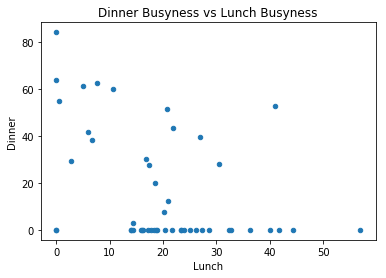

In [27]:
final_df.plot.scatter(x = 'lunch_avg', y = 'l8_nite_avg')
plt.title("Dinner Busyness vs Lunch Busyness")
plt.ylabel('Dinner')
plt.xlabel('Lunch')
plt.savefig('project_plot_not_colorcoded.png')

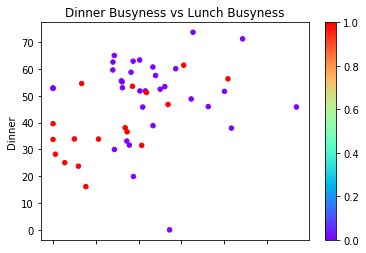

In [28]:
final_df.plot.scatter(x = 'lunch_avg', y = 'dinner_avg', c=labels, colormap='rainbow')
plt.title("Dinner Busyness vs Lunch Busyness")
plt.ylabel('Dinner')
plt.xlabel('Lunch')
plt.savefig('dinner_lunch_plot.png')

In [29]:
labels

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0], dtype=int64)

In [30]:
# scaling for PCA
from sklearn.preprocessing import StandardScaler

pca_df = data1
pca_df_final = StandardScaler().fit_transform(pca_df)

In [31]:
# Plotting datafram
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_df_final)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

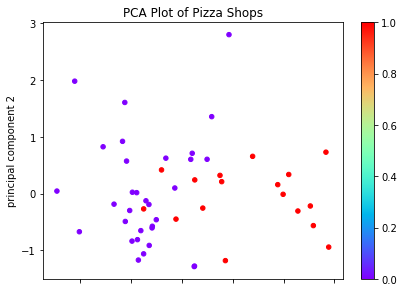

In [32]:
principalDf.plot.scatter('principal component 1', 'principal component 2', c=labels, colormap='rainbow')
plt.tight_layout()
plt.title("PCA Plot of Pizza Shops")
plt.savefig('pca_colorcodedbycluster.png')

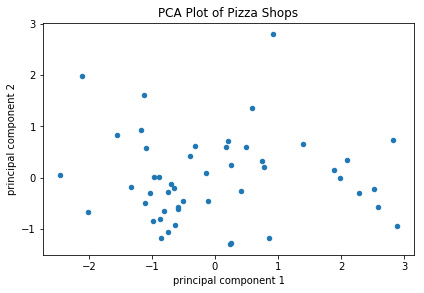

In [33]:
final_df.area = pd.Categorical(final_df.area)
final_df['area code'] = final_df.area.cat.codes
principalDf.plot.scatter('principal component 1', 'principal component 2')
plt.tight_layout()
plt.title("PCA Plot of Pizza Shops")
plt.savefig('PCA_Plot_pizza_not_colorcoded.png')

In [34]:
final_df.iloc[:, 9]
final_df.columns

Index(['restaurant', 'area', 'weekday_lunch_avg', 'weekend_lunch_avg',
       'lunch_avg', 'weekday_dinner_avg', 'weekend_dinner_avg', 'dinner_avg',
       'l8_nite_avg', 'area code'],
      dtype='object')

In [35]:
# How are the clusters different?
final_df['Cluster'] = labels
restaurants = final_df.restaurant.tolist()
# adding cluster assignment to the original pizza dataframe
new_df = pd.DataFrame()
for i in set(pizza_df['id']):
    rest = pizza_df[pizza_df['id'] == i]
    restaurant = rest.iloc[0,2]
    rest_index = restaurants.index(restaurant)
    clust_num = final_df.iloc[rest_index, 10]
    rest["Cluster"] = [clust_num]*24
    new_df = pd.concat([new_df, rest])
new_df.head()

C:\Users\cathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,id,Neighb,Restaurant,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,UpdatedHour,WeekdayHourSum,WeekendHourSum,Cluster
792,ChIJFQHMOa-AhYARnfFStDNx8c8,Polk,Presidio Pizza Company,0.0,0.0,0.0,0.0,0.0,0.0,30.0,46.0,24.0,0.0,76.0,1
793,ChIJFQHMOa-AhYARnfFStDNx8c8,Polk,Presidio Pizza Company,1.0,0.0,0.0,0.0,0.0,0.0,16.0,76.0,25.0,0.0,92.0,1
794,ChIJFQHMOa-AhYARnfFStDNx8c8,Polk,Presidio Pizza Company,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,1
795,ChIJFQHMOa-AhYARnfFStDNx8c8,Polk,Presidio Pizza Company,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1
796,ChIJFQHMOa-AhYARnfFStDNx8c8,Polk,Presidio Pizza Company,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1


In [36]:
set(new_df['Cluster'])

{0, 1}

In [37]:
# Grouping new_df by cluster assignment to plot time distribution
#new_df.groupby("Cluster")[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sum()
#clust_hour = new_df.groupby(['Cluster', 'Hour'])[['Hour']].sum()
#clust_hour[clust_hour.index==[0]]

# The clusters are numbered 2 and 4
clust2 = new_df[new_df['Cluster']==1]
clust3 = new_df[new_df['Cluster']==0]

# Need to find the number of restuarant in each cluster
# Need to sum busyness for each hour for each restaurant in each cluster

num2 = len(clust2.groupby('Restaurant')['Saturday'].sum())
sat_sums2 = clust2.groupby(['Restaurant', 'Hour'])['Saturday'].sum()

num3 = len(clust3.groupby('Restaurant')['Saturday'].sum())
sat_sums3 = clust3.groupby(['Restaurant', 'Hour'])['Saturday'].sum()

data2 = []
for i in range(num2):
    rest = [sat_sums2.index.get_level_values(0)[i*24]]
    sums2 = sat_sums2[i*24:i*24+24].tolist()
    data2.append(sums2)
    
clust2_hourly = pd.DataFrame(data2)
clust2_hourly_sums = clust2_hourly.sum().tolist()
clust2_hourly_avg = [s/num2 for s in clust2_hourly_sums]
print(clust2_hourly_avg)

data3 = []
for i in range(num3):
    rest = [sat_sums3.index.get_level_values(0)[i*24]]
    sums3 = sat_sums3[i*24:i*24+24].tolist()
    data3.append(sums3)

clust3_hourly = pd.DataFrame(data3)
clust3_hourly_sums = clust3_hourly.sum().tolist()
clust3_hourly_avg = [s/num3 for s in clust3_hourly_sums]
print(clust3_hourly_avg)

[57.529411764705884, 48.411764705882355, 8.529411764705882, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4117647058823529, 4.294117647058823, 11.176470588235293, 20.11764705882353, 21.294117647058822, 24.529411764705884, 31.058823529411764, 39.76470588235294, 49.529411764705884, 59.94117647058823, 68.0, 67.11764705882354, 61.529411764705884, 66.58823529411765]
[1.5625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 2.15625, 12.1875, 24.59375, 33.71875, 34.1875, 33.1875, 36.59375, 48.78125, 65.34375, 75.78125, 66.78125, 48.1875, 23.9375, 7.84375]


Text(0, 0.5, 'Busyness')

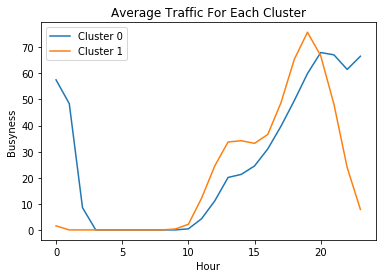

In [38]:
# Plotting the distributions
hours = list(range(0,24))
plt.plot(clust2_hourly_avg) 
plt.plot(clust3_hourly_avg)
plt.legend(['Cluster 0', 'Cluster 1'])
plt.title('Average Traffic For Each Cluster')
plt.xlabel('Hour')
plt.ylabel('Busyness')

Text(0, 0.5, 'Busyness')

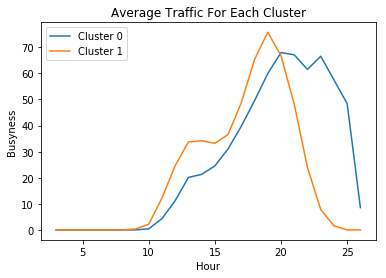

In [39]:
# Shifting the hours
new_clust2_hourly = clust2_hourly_avg[3:]+clust2_hourly_avg[:3]
new_clust3_hourly = clust3_hourly_avg[3:]+clust3_hourly_avg[:3]
new_hours = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

plt.plot(new_hours, new_clust2_hourly)
plt.plot(new_hours, new_clust3_hourly)
plt.legend(['Cluster 0', 'Cluster 1'])
plt.title('Average Traffic For Each Cluster')
plt.xlabel('Hour')
plt.ylabel('Busyness')

In [42]:
# Finding the Variance-Covariance Matrices for the two clusters
#print("Cluster Means: \n", fit.means_)
#print("\nCluster Covariance Matrices: \n", fit.covariances_)

In [28]:
# Where are the areas for each cluster
#set(clust3['Neighb'])
clust3_area_count = clust3.groupby(['Restaurant','Neighb'])['id'].count()
clust2_area_count = clust2.groupby(['Restaurant','Neighb'])['id'].count()
test = list(clust2_area_count.index.get_level_values(1))

In [30]:
clust3_area_count

Restaurant                  Neighb            
Donairo's Pizza             Richmond              24
Golden Boy Pizza            North Beach           24
Himalayan Pizza & Momo      Fillmore              24
Mr. Pizza Man               Mission               24
Nizario's Pizza (Broadway)  North Beach           24
Nizario's Pizza Geary Blvd  Richmond              24
Nizario's Pizza The Castro  Mission               24
Papa John's Pizza           Polk                  24
Paris Pizza & Grill         North Beach           24
Pizzelle di North Beach     North Beach           24
Presidio Pizza Company      Polk                  24
Primo Pizza                 Fillmore              24
SF Hole In The Wall Pizza   Sunset                24
SF Hole in the Wall Pizza   Polk                  24
Sam’s Pizza & Burgers       North Beach           24
Seniore's Pizza             Fillmore              24
SoMa Pizza                  Financial District    24
Name: id, dtype: int64

In [31]:
list(clust2_area_count.index.get_level_values(1))

['Polk',
 'Fillmore',
 'Financial District',
 'Sunset',
 'Financial District',
 'Financial District',
 'Richmond',
 'Richmond',
 'Richmond',
 'Financial District',
 'Sunset',
 'North Beach',
 'Financial District',
 'Fillmore',
 'North Beach',
 'Financial District',
 'Polk',
 'Fillmore',
 'Richmond',
 'Mission',
 'Polk',
 'Financial District',
 'Richmond',
 'Mission',
 'Sunset',
 'North Beach',
 'North Beach',
 'Financial District',
 'Mission',
 'Polk',
 'Richmond',
 'Polk']

In [32]:
list(clust3_area_count.index.get_level_values(1))

['Richmond',
 'North Beach',
 'Fillmore',
 'Mission',
 'North Beach',
 'Richmond',
 'Mission',
 'Polk',
 'North Beach',
 'North Beach',
 'Polk',
 'Fillmore',
 'Sunset',
 'Polk',
 'North Beach',
 'Fillmore',
 'Financial District']

In [71]:
test = list(clust2_area_count.index.get_level_values(1))


<bound method IndexOpsMixin.value_counts of Restaurant                  Neighb            
Donairo's Pizza             Richmond              24
Golden Boy Pizza            North Beach           24
Himalayan Pizza & Momo      Fillmore              24
Mr. Pizza Man               Mission               24
Nizario's Pizza (Broadway)  North Beach           24
Nizario's Pizza Geary Blvd  Richmond              24
Nizario's Pizza The Castro  Mission               24
Papa John's Pizza           Polk                  24
Paris Pizza & Grill         North Beach           24
Pizzelle di North Beach     North Beach           24
Presidio Pizza Company      Polk                  24
Primo Pizza                 Fillmore              24
SF Hole In The Wall Pizza   Sunset                24
SF Hole in the Wall Pizza   Polk                  24
Sam’s Pizza & Burgers       North Beach           24
Seniore's Pizza             Fillmore              24
SoMa Pizza                  Financial District    24
Name: id